In [1]:
from PIL import Image
import torch
from models.model import MyModel

/opt/conda/envs/mmm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import argparse
args = argparse.Namespace(
    # Model setting
    float_type='bfloat16',
    image_model_name="microsoft/swinv2-large-patch4-window12to16-192to256-22kto1k-ft",
    image_model_train=False,
    language_model_name="google/flan-t5-large",
    language_model_train=False,
    ffn=True,
    transformer_d_model=768,
    transformer_d_ff=3072,
    transformer_d_kv=64,
    transformer_num_heads=12,
    transformer_num_layers=2,
    transformer_num_decoder_layers=12,
    loc_vocab_size=1600,
    additional_vocab_size=10000,
    vae_ckpt_path='',
    max_source_length=512,
    max_target_length=512,
    # Train setting
    stage="train", 
    loss='CrossEntropy',
    # Dir setting
    root_dir="/data01/",
    result_dir="results/train/all/enc2_dec12/Linear50_1e-4",
)

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
model = MyModel(args).to(device)
model.load(result_name='best.pth')

In [5]:
from transformers import AutoTokenizer
from torchvision import transforms
src_tokenizer = AutoTokenizer.from_pretrained(args.language_model_name, model_max_length=args.max_source_length)
tgt_tokenizer = AutoTokenizer.from_pretrained(args.language_model_name, model_max_length=args.max_target_length, use_fast=True, extra_ids=0, additional_special_tokens =[f"<extra_id_{i}>" for i in range(100)] + [f"<loc_{i}>" for i in range(args.loc_vocab_size)] + [f"<add_{i}>" for i in range(args.additional_vocab_size)])
resize=256
src_transforms = transforms.Compose([
    transforms.Resize((resize, resize)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                            std=[0.229, 0.224, 0.225]),
])
tgt_transforms = transforms.Compose([
    transforms.Resize((resize, resize)),
    transforms.ToTensor(),
])

In [6]:
import numpy as np
def custom_to_pil(x):
  x = x.detach().cpu().numpy()
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  x = (((x.transpose(1, 2, 0) * std) + mean) * 255.).astype(np.uint8)

  x = Image.fromarray(x)
  if not x.mode == "RGB":
    x = x.convert("RGB")
  return x

In [141]:
from PIL import ImageDraw
def show_result(dataset, idx=10, src_loc=True):
    src_image, tgt_image, src_text, tgt_text = dataset[idx]
    scale = 256 / 40
    bias = scale // 2
    with torch.no_grad():
        src_image = src_image.unsqueeze(0).to(device)
        tokenized_text = src_tokenizer(src_text, return_tensors='pt', padding=True)['input_ids'].to(device)
        src_attention_mask = torch.ones_like(tokenized_text).to(device)

        pil = custom_to_pil(src_image[0])
        display(pil)

        if '<loc_' in src_text and src_loc:
            draw = ImageDraw.Draw(pil)
            locs = src_text.split()
            for loc in locs:
                if '<loc_' in loc:
                    label, l1, l2 = loc.split('<loc_')
                    l2 = l2.rstrip('?')
                    left_top, right_bottom = int(l1.rstrip('>')), int(l2.rstrip('>'))
                    draw.rectangle((left_top%40*scale+bias, left_top//40*scale+bias, right_bottom%40*scale+bias, right_bottom//40*scale+bias), fill=None, outline='blue', width=3)
                    draw.text((left_top%40*scale+bias, left_top//40*scale+bias), label, fill='blue')
            display(pil)
            
        output = model(src_image, tokenized_text, src_attention_mask, return_loss=False, num_beams=4)
        pred = tgt_tokenizer.decode(output[0,1:-1])
        
        if '<loc_' in tgt_text:
            draw = ImageDraw.Draw(pil)
            locs = tgt_text.split('> ')
            for loc in locs:
                label, l1, l2 = loc.split('<loc_')
                left_top, right_bottom = int(l1.rstrip('>')), int(l2.rstrip('>'))
                draw.rectangle((left_top%40*scale+bias, left_top//40*scale+bias, right_bottom%40*scale+bias, right_bottom//40*scale+bias), fill=None, outline='green', width=3)
                draw.text((left_top%40*scale+bias, left_top//40*scale+bias), label, fill='green')
            display(pil)
        if '<loc_' in pred:
            pil = custom_to_pil(src_image[0])
            draw = ImageDraw.Draw(pil)
            locs = pred.split('> ')
            for loc in locs:
                label, l1, l2 = loc.split('<loc_')
                left_top, right_bottom = int(l1.rstrip('>')), int(l2.rstrip('>'))
                draw.rectangle((left_top%40*scale+bias, left_top//40*scale+bias, right_bottom%40*scale+bias, right_bottom//40*scale+bias), fill=None, outline='red', width=3)
                draw.text((left_top%40*scale+bias, left_top//40*scale+bias), label, fill='red')
            display(pil)

        print('input:', src_text)
        print('gt:', tgt_text)
        print('pred:', pred)

# SUN397

In [8]:
from data import get_dataset
dataset = get_dataset(args.root_dir, dataset_name='sun397', stage='train', phase='val')

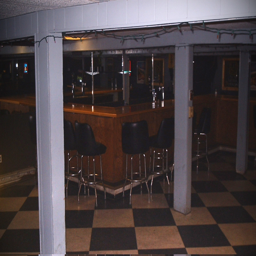

input: What is in this image?
gt: bar
pred: bar


In [27]:
# Good: 1000, Bad: 1500
show_result(dataset, idx=1000)

# ImageNet

In [ ]:
from data import get_dataset
dataset = get_dataset(args.root_dir, dataset_name='imagenet', stage='train', phase='val')

In [ ]:
show_result(dataset, idx=15)

## ImageNet21K

In [40]:
from data import get_dataset
dataset = get_dataset(args.root_dir, dataset_name='imagenet21k', stage='train', phase='val')

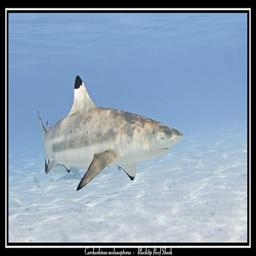

input: What is in this image?
gt: blacktip_shark sandbar_shark Carcharhinus_limbatus
pred: blacktip_shark sandbar_shark Carcharhinus_limbatus


In [48]:
# Good: 200, Bad: 900
show_result(dataset, idx=2000)

# Places365

In [49]:
from data import get_dataset
dataset = get_dataset(args.root_dir, dataset_name='places365', stage='train', phase='val')

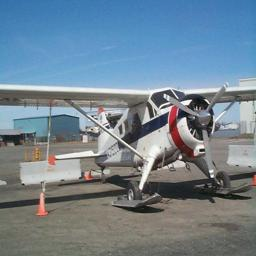

input: What is in this image?
gt: airfield
pred: airfield


In [51]:
# Good: 500, Bad: 10
show_result(dataset, idx=0)

# RedCaps

In [52]:
from data import get_dataset
dataset = get_dataset(args.root_dir, dataset_name='redcaps', stage='train', phase='val')

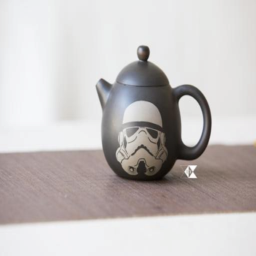

input: What does the image describe?
gt: There may never be a teapot added to my collection that can top this custom made Jianshui.
pred: My first attempt at a teapot. I think it's a teapot, but I'm happy with how it turned out!


In [55]:
# Good: 3, Bad: 10
show_result(dataset, idx=100)

# CC3M

In [56]:
from data import get_dataset
dataset = get_dataset(args.root_dir, dataset_name='cc3m', stage='train', phase='val')

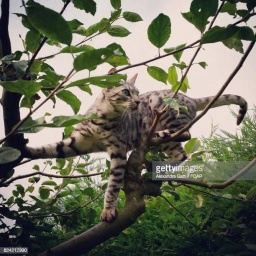

input: What does the image describe?
gt: close - up of a cat on tree branch
pred: a tabby cat on a tree.


In [63]:
# Good: 10, Bad: 20
show_result(dataset, idx=10)

# CC12M

In [64]:
from data import get_dataset
dataset = get_dataset(args.root_dir, dataset_name='cc12m', stage='train', phase='val')

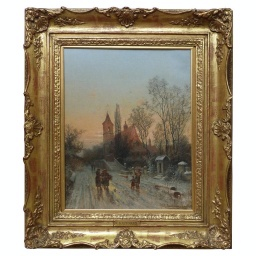

input: What does the image describe?
gt: <PERSON> of a European Village Landscape
pred: <unk>PERSON>, <unk>PERSON>, <unk>PERSON>, <unk>PERSON>, <unk>PERSON>, <unk>PERSON>, <unk>PERSON>, <unk>PERSON>, <unk>PERSON>, <unk>PERSON>, <unk>PERSON>, <unk>PERSON>, <unk>PERSON>, <unk>PERSON>, <unk>PERSON>, <unk>PERSON>, <unk>PERSON>, <unk>PERSON>, <unk>PERSON>, <unk>PERSON>, <unk>PERSON>


In [71]:
# Good: 21, Bad: 10
show_result(dataset, idx=10)

# Region Caption

In [154]:
from data import get_dataset
dataset = get_dataset(args.root_dir, dataset_name='grit20m_rcap', stage='train', phase='val')

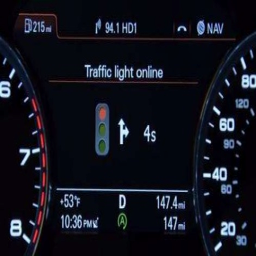

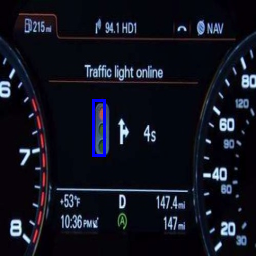

input: What does the region <loc_614><loc_976> describe?
gt: those green lights
pred: a speedometer


In [164]:
show_result(dataset, idx=10000)

# Reference Expression

In [186]:
from data import get_dataset
dataset = get_dataset(args.root_dir, dataset_name='grit20m_refexp', stage='train', phase='val')

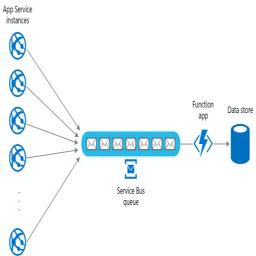

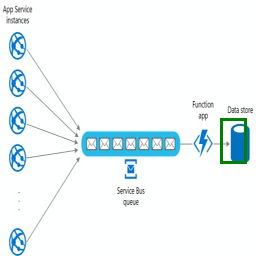

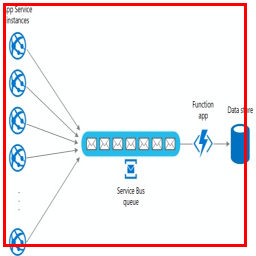

input: Which region does the text "a function app" describe?
gt: <loc_754><loc_1038>
pred: <loc_0><loc_1558>


In [193]:
show_result(dataset, idx=20)

# VG_Relationships

In [94]:
from data import get_dataset
dataset = get_dataset(args.root_dir, dataset_name='vg_rel', stage='train', phase='val')

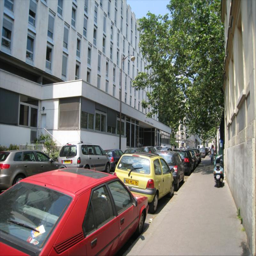

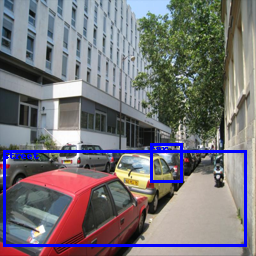

input: What is the relationship between car<loc_903><loc_1148> and street<loc_920><loc_1558>?
gt: car ON street
pred: car parked on street


In [100]:
show_result(dataset, idx=1000)

# Detection

In [101]:
from data import get_dataset
dataset = get_dataset(args.root_dir, dataset_name='objects365_det', stage='train', phase='val')

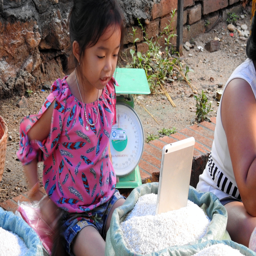

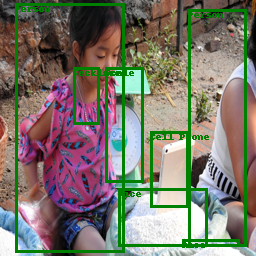

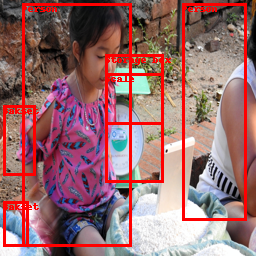

input: What objects are in the image?
gt: Cell Phone<loc_823><loc_1309> Necklace<loc_411><loc_775> Person<loc_2><loc_1579> Person<loc_69><loc_1558> Rice<loc_1178><loc_1552> Rice<loc_1508><loc_1557> Scale<loc_416><loc_1142>
pred: Bakset<loc_640><loc_1085> Bakset<loc_1240><loc_1524> Person<loc_3><loc_1540> Person<loc_28><loc_1398> Scale<loc_456><loc_1145> Storage box<loc_336><loc_785>


In [110]:
show_result(dataset, idx=40)

# Localization

In [171]:
from data import get_dataset
dataset = get_dataset('/data/dataset', dataset_name='openimage_loc', stage='train', phase='val')

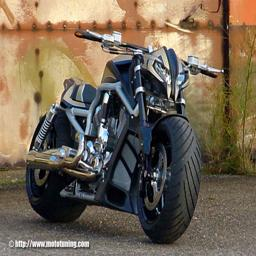

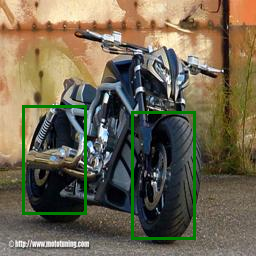

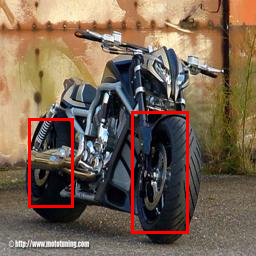

input: Which regions does the text "Wheel" describe?
gt: <loc_643><loc_1333> <loc_700><loc_1510>
pred: <loc_700><loc_1469> <loc_724><loc_1291>


In [175]:
show_result(dataset, idx=100)

# Categorization

In [177]:
from data import get_dataset
dataset = get_dataset('/data/dataset', dataset_name='openimage_cat', stage='train', phase='val')

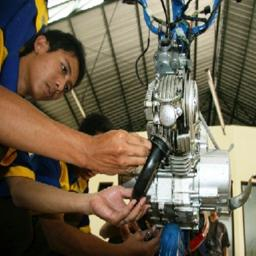

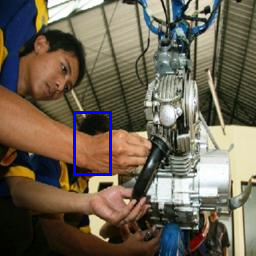

input: What is the category of the region <loc_691><loc_1097>?
gt: Human head
pred: Person


In [185]:
show_result(dataset, idx=100)

# VQA

## VQA2

In [111]:
from data import get_dataset
dataset = get_dataset('/data/dataset', dataset_name='vqa2', stage='train', phase='val')

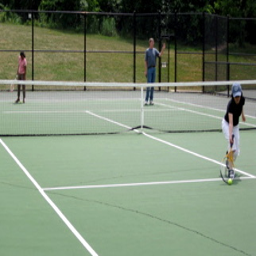

input: What color is the court?
gt: green
pred: Green.


In [123]:
show_result(dataset, idx=200)

## VG_VQA

In [124]:
from data import get_dataset
dataset = get_dataset('/data01', dataset_name='vg_vqa', stage='train', phase='val')

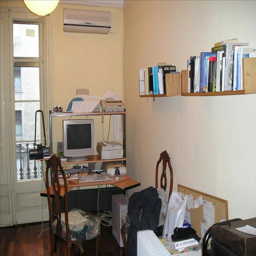

input: What is in front of the computer CPU?
gt: Suitcase.
pred: keyboard


In [132]:
show_result(dataset, idx=200)

# GVQA

In [150]:
from data import get_dataset
dataset = get_dataset('/data01', dataset_name='visual7w_gvqa', stage='train', phase='val')

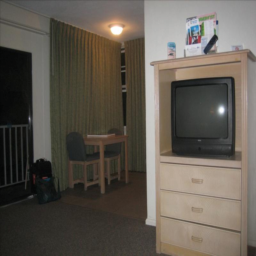

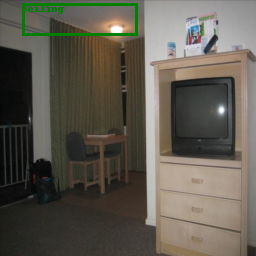

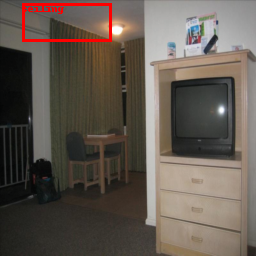

input: Which has ceiling light aglow? choices: ceiling<loc_3><loc_221>,luggage<loc_964><loc_1249>,drawers<loc_1024><loc_1556>,night<loc_258><loc_819>
gt: ceiling<loc_3><loc_221>
pred: ceiling<loc_3><loc_257>


In [153]:
show_result(dataset, idx=100, src_loc=False)